In [11]:
pip install cython

  Using cached Cython-0.29.21-cp38-cp38-macosx_10_9_x86_64.whl (1.9 MB)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import photutils

In [5]:
%cd anaconda3/envs/reduction/lib/python3.7/site-packages

/Users/holdengill/anaconda3/envs/reduction/lib/python3.7/site-packages


In [4]:
import os
import numpy as np
import scipy as sp
import pandas as pd
from astropy.stats import SigmaClip
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import photutils
from photutils.aperture import CircularAnnulus
#import mpdaf
#from mpdaf.obj import Image, WCS

In [162]:
%cd test/SImMER/src/simmer/K2

/Users/holdengill/test/SImMER/src/simmer/K2


In [118]:
def contrast_curve_3(data,center=None,remove_hot=False,background_method='outside',radius_size=1):
    
    star_data=data.copy()
    
    x, y = np.indices((star_data.shape))
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
        
    center_x1,center_x2 = int(center[0]-.5) ,int(center[0]+.5)
    center_y1,center_y2 = int(center[1]-.5),int(center[1]+.5)
    center_points = (star_data[center_x1,center_y1],star_data[center_x1,center_y2],star_data[center_x2,center_y1],star_data[center_x2,center_y2])
    center_val = np.mean(center_points)/(4) + 5*np.std(center_points)
    
    radii =  np.sqrt((x - center[0])**2 + (y - center[1])**2)
    radii = radii.astype(np.int)

    #Method 1 for background - Everything outside center (bad for companions)
    if background_method=='outside':
        non_center = []
        for i in range(len(star_data)):
            for j in range(len(star_data[i])):
                if i<265 or i>335 or j<265 or j>335:
                    non_center.append(star_data[i,j])
        background_mean = np.mean(non_center)
        background_std = np.std(non_center)
    
    #Method 2 for background - 4 Box method (remove a box if it is wonky/high)
    if background_method=='boxes':
        box1,box2,box3,box4=star_data[100:200,100:200],star_data[100:200,400:500],star_data[400:500,100:200],star_data[400:500,400:500]
        mean_box1,mean_box2,mean_box3,mean_box4 = np.mean(box1),np.mean(box2),np.mean(box3),np.mean(box4)
        std_box1,std_box2,std_box3,std_box4 = np.std(box1),np.std(box2),np.std(box3),np.std(box4)
        
        mean_boxes = []
        std_boxes = []
        if mean_box1 < (10*np.mean([std_box2,std_box3,std_box4]) + np.mean([mean_box2,mean_box3,mean_box4])):
            mean_boxes.append(mean_box1)
            std_boxes.append(std_box1)
        if mean_box2 < (10*np.mean([std_box1,std_box3,std_box4]) + np.mean([mean_box1,mean_box3,mean_box4])):
            mean_boxes.append(mean_box2)
            std_boxes.append(std_box2)
        if mean_box3 < (10*np.mean([std_box1,std_box2,std_box4]) + np.mean([mean_box1,mean_box2,mean_box4])):
            mean_boxes.append(mean_box3)
            std_boxes.append(std_box3)
        if mean_box4 < (10*np.mean([std_box2,std_box3,std_box1]) + np.mean([mean_box2,mean_box3,mean_box1])):
            mean_boxes.append(mean_box4)
            std_boxes.append(std_box4)
        background_mean = np.mean(mean_boxes)
        background_std = np.mean(std_boxes)
        print('box means:',mean_boxes,'box stds:',std_boxes)
    #Method 3 for background - simple astropy
    if background_method=='astropy':
        background_mean,background_median,background_std = sigma_clipped_stats(star_data,sigma=5)
    
    
    
    number_of_a = radii.max()/radius_size
    if radius_size>1:
        for i in range(int(number_of_a)+2):
            if i==0:
                continue
            radii[(radii>0) & (radii<=i*radius_size) & (radii>radius_size*(i-1))] =(i)
            
    
    radii_arc_length = []
    bins=[]
    for i in range(radii.max()+1):
        radii_arc_length.append(i*0.033*radius_size + 0.033)
        bins.append([])
    radii_arc_length = np.array(radii_arc_length)
    lim_arc_length=radii_arc_length
    lim_arc_length= radii_arc_length[radii_arc_length<8]
    
    for i in range(len(radii)):
        for j in range(len(radii[i])):
            bins[radii[i,j]].append(np.array([i,j]))
    bins = bins[:len(lim_arc_length)]
    
    #Remove hot pixel (only works for non binary atm)
    if remove_hot==True:
        print('looking for hots')
        for i in range(600):
            for j in range(600):
                if (i<265 or i>335 or j<265 or j>335) & (star_data[i,j]>(background_mean+10*background_std)):
                    print('hot pixel alert:',star_data[i,j],'at',[i,j],'arc_length',)
                    star_data[i,j] = np.mean([star_data[i+1,j],star_data[i-1,j],star_data[i,j+1],star_data[i,j-1]])
    
    radii_bin_vals = []
    for i in range(len(bins)):
        radii_bin = []
        for j in range(len(bins[i])):
            radii_bin.append(star_data[bins[i][j][0],bins[i][j][1]])
        radii_bin_vals.append(radii_bin)
    radii_deltas = []
    
    
    
    print(background_mean,background_std)
    
    
    rbv_count = 0
    for i in radii_bin_vals:
        rbv_count+=1
        if np.mean(i)>0:
            radii_deltas.append(-2.5 * math.log(((np.mean(i)/(len(i))) + 5*np.std(i))/center_val,10))
        else:
            print('mean less than zero in bin',rbv_count,'val of',np.mean(i))
    radii_deltas=np.array(radii_deltas)
    return np.array([lim_arc_length,radii_deltas])

In [73]:
#Good example acrosss the board:
contrast_curve_3(all_ks_data[12][0],background_method='outside')
contrast_curve_3(all_ks_data[12][0],background_method='boxes')
contrast_curve_3(all_ks_data[12][0],background_method='astropy')

4.999042795706539 5.069694515759528
5.382502934751475 4.530311823476063
5.031922170972533 5.002477507990015


In [75]:
#Example with a companion (box method does not touch companion)
contrast_curve_3(all_ks_data[2][1],background_method='outside')
contrast_curve_3(all_ks_data[2][1],background_method='boxes')
contrast_curve_3(all_ks_data[2][1],background_method='astropy')

16.780768811656714 132.6040380565719
9.981126469057648 11.00508879347942
8.783238964862 12.934588109854289


9.351568555991882 13.195276516276722
box means: [11.18881273914044, 1.0603053783346958, 7.4210252654260955, 6.538851812666734] box stds: [9.459173884476892, 3.1063700767610856, 8.1315661382071, 7.875680681480683]
6.552248798891991 7.143197695231439
8.581407157399356 10.314290651404745


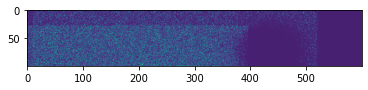

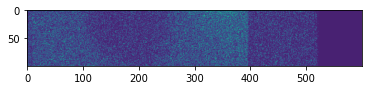

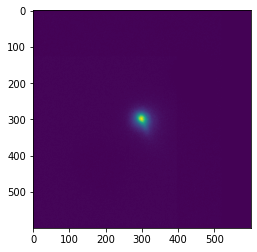

In [85]:
#Example with no companion but weird part of data
contrast_curve_3(all_ks_data[10][1],background_method='outside')
contrast_curve_3(all_ks_data[10][1],background_method='boxes')
contrast_curve_3(all_ks_data[10][1],background_method='astropy')

#Area which screws up box method:
plt.imshow(all_ks_data[10][1][100:200,:])
plt.show()
plt.imshow(all_ks_data[10][1][400:500,:])
plt.show()
plt.imshow(all_ks_data[10][1])

16.780768811656714 132.6040380565719


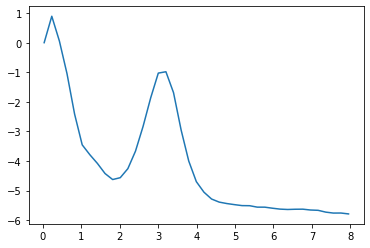

In [119]:
test_center = all_ks_data[2][1][290:310,290:310]
#plt.plot(contrast_curve_3(test_center,radius_size=2)[0],-1*contrast_curve_3(test_center,radius_size=2)[1])
cc_2_1 = contrast_curve_3(all_ks_data[2][1],background_method='outside',radius_size=6)
plt.plot(cc_2_1[0],-1*cc_2_1[1])

8.783238964862 12.934588109854289


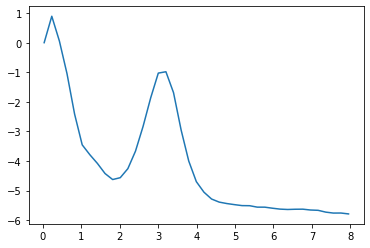

In [120]:
cc_2_1_2 = contrast_curve_3(all_ks_data[2][1],background_method='astropy',radius_size=6)
plt.plot(cc_2_1_2[0],-1*cc_2_1_2[1])

In [32]:
CA = CircularAnnulus([10,10],3,5)
CA.area

50.26548245743669

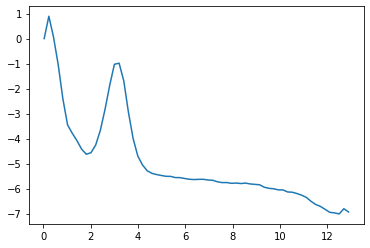

In [153]:
plt.plot(cc_2_1[0],-1*cc_2_1[1])

In [10]:
x, y = np.indices((all_ks_data[6][1].shape))

center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])  
center_x1,center_x2 = int(center[0]-.5) ,int(center[0]+.5)
center_y1,center_y2 = int(center[1]-.5),int(center[1]+.5)
    
radii =  np.sqrt((x - center[0])**2 + (y - center[1])**2)
radii = radii.astype(np.int)

radius_size=3
number_of_a = radii.max()/radius_size
if radius_size>1:
    for i in range(int(number_of_a)+2):
        if i==0:
            continue
        radii[(radii>0) & (radii<=i*radius_size) & (radii>radius_size*(i-1))] =(i)
            
print(radii[290:310,290:310])

[[5 4 4 4 4 4 4 3 3 3 3 3 3 4 4 4 4 4 4 5]
 [4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4]
 [4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4]
 [4 4 3 3 3 3 3 2 2 2 2 2 2 3 3 3 3 3 4 4]
 [4 4 3 3 3 3 2 2 2 2 2 2 2 2 3 3 3 3 4 4]
 [4 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4]
 [4 3 3 3 2 2 2 2 1 1 1 1 2 2 2 2 3 3 3 4]
 [3 3 3 2 2 2 2 1 1 1 1 1 1 2 2 2 2 3 3 3]
 [3 3 3 2 2 2 1 1 1 1 1 1 1 1 2 2 2 3 3 3]
 [3 3 3 2 2 2 1 1 1 0 0 1 1 1 2 2 2 3 3 3]
 [3 3 3 2 2 2 1 1 1 0 0 1 1 1 2 2 2 3 3 3]
 [3 3 3 2 2 2 1 1 1 1 1 1 1 1 2 2 2 3 3 3]
 [3 3 3 2 2 2 2 1 1 1 1 1 1 2 2 2 2 3 3 3]
 [4 3 3 3 2 2 2 2 1 1 1 1 2 2 2 2 3 3 3 4]
 [4 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4]
 [4 4 3 3 3 3 2 2 2 2 2 2 2 2 3 3 3 3 4 4]
 [4 4 3 3 3 3 3 2 2 2 2 2 2 3 3 3 3 3 4 4]
 [4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4]
 [4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4]
 [5 4 4 4 4 4 4 3 3 3 3 3 3 4 4 4 4 4 4 5]]


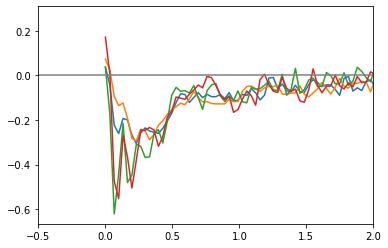

In [47]:
for i in stars_data:
    plt.plot(contrast_curve(i)[0],np.gradient(-contrast_curve(i)[1]))
    plt.xlim(-.5,2)
    
x = np.linspace(-1,2,1000)
vert = np.linspace(-1,.7,1000)
plt.plot(x,x*0,color='grey')
#plt.plot(vert*0 + .198,vert,color='black')
#plt.plot(vert*0 + .231,vert,color='black')
#plt.plot(vert*0 + .462,vert,color='black')
#plt.plot(vert*0 + .891,vert,color='black')
#plt.plot(vert*0 + .924,vert,color='black')
#plt.plot(vert*0 +1.155,vert,color='black')

In [45]:
grad_0 = []
current = 0
previous = 0
grad_func = np.gradient(-contrast_curve(stars_data[3])[1])
CCfunc = contrast_curve(stars_data[3])[0]
for j in range(len(grad_func)):
    previous = current
    current=grad_func[j]
    if (previous>0 and current<0) or (previous<0 and current>0):
        grad_0.append(CCfunc[j])

In [311]:
len(np.gradient(-contrast_curve(stars_data[1])[1]))
len(contrast_curve(stars_data[1])[0])

304

[-0.0, -0.18999223378205626]
[-0.0, -0.18999223378205626]
[-0.0, -0.18999223378205626]
[-0.0, -0.18999223378205626]
[-0.0, -0.31904442295682045]
[-0.0, -0.31904442295682045]
[-0.0, -0.31904442295682045]
[-0.0, -0.31904442295682045]


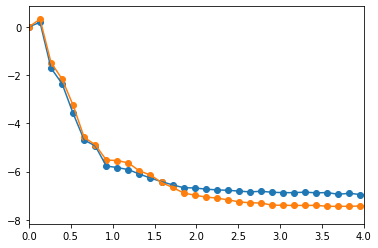

In [100]:
new = stars_data[2:]
for i in new:
    plt.plot(contrast_curve_3(i,radius_size=4)[0],-1*contrast_curve_3(i,radius_size=4)[1])
    plt.scatter(contrast_curve_3(i,radius_size=4)[0],-1*contrast_curve_3(i,radius_size=4)[1])
    plt.xlim(0,4)

In [10]:
all_ks_data = []
all_j_data = []
all_h_data = []

all_ks_names = []
all_j_names = []
all_h_names = []


Jul_20_2018_Ks_stars = ['220383386']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Jul_20_2018/' + i +'/Ks/final_im.fits')[0].data for i in Jul_20_2018_Ks_stars))
all_ks_names.append(Jul_20_2018_Ks_stars)


Jul_22_2018_Ks_stars = ['204888276','205111664']
Jul_22_2018_J_stars = ['204888276','205111664']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Jul_22_2018/' + i +'/Ks/final_im.fits')[0].data for i in Jul_22_2018_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Jul_22_2018/' + i +'/J/final_im.fits')[0].data for i in Jul_22_2018_J_stars))
all_ks_names.append(Jul_22_2018_Ks_stars)
all_j_names.append(Jul_22_2018_J_stars)


Dec_22_2018_Ks_stars = ['210903662','210954046','211620138','211770867','212178066','247166577','248212342']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Dec_22_2018/' + i +'/Ks/final_im.fits')[0].data for i in Dec_22_2018_Ks_stars))
all_ks_names.append(Dec_22_2018_Ks_stars)


Dec_23_2018_Ks_stars = ['37749396','210894022']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Dec_23_2018/' + i +'/Ks/final_im.fits')[0].data for i in Dec_23_2018_Ks_stars))
all_ks_names.append(Dec_23_2018_Ks_stars)


Jan_21_2019_Ks_stars = ['201488365','201779067','202059377','212530247','229021605']
Jan_21_2019_J_stars = ['201488365','212530247']
Jan_21_2019_H_stars = ['212530247']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Jan_21_2019/' + i +'/Ks/final_im.fits')[0].data for i in Jan_21_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Jan_21_2019/' + i +'/J/final_im.fits')[0].data for i in Jan_21_2019_J_stars))
all_h_data.append(tuple(fits.open('Reduced_Directory_Jan_21_2019/' + i +'/H/final_im.fits')[0].data for i in Jan_21_2019_H_stars))
all_ks_names.append(Jan_21_2019_Ks_stars)
all_j_names.append(Jan_21_2019_J_stars)
all_h_names.append(Jan_21_2019_H_stars)



Jan_22_2019_Ks_stars = ['16467175','201257461','201649426','202066192','202071635','202083828','202126849',
                       '202126888','210363145','210402237','212060053','212099230','212194007','212461484',
                       '212679181','229021605','268766053']
Jan_22_2019_J_stars = ['202071635','202126888','212679181']
Jan_22_2019_H_stars = ['212679181']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Jan_22_2019/' + i +'/Ks/final_im.fits')[0].data for i in Jan_22_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Jan_22_2019/' + i +'/J/final_im.fits')[0].data for i in Jan_22_2019_J_stars))
all_h_data.append(tuple(fits.open('Reduced_Directory_Jan_22_2019/' + i +'/H/final_im.fits')[0].data for i in Jan_22_2019_H_stars))
all_ks_names.append(Jan_22_2019_Ks_stars)
all_j_names.append(Jan_22_2019_J_stars)
all_h_names.append(Jan_22_2019_H_stars)


Jan_23_2019_Ks_stars = ['202064253','202071635','202072965','202086291','202091388','202094117','210403955',
                        '211804579','211923431','211997641','212040382','212081533','212114260','212521166',
                        '212686205','229021605','246953392','247450113','248767140','251380988']
Jan_23_2019_J_stars = ['202071635','211804579']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Jan_23_2019/' + i +'/Ks/final_im.fits')[0].data for i in Jan_23_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Jan_23_2019/' + i +'/J/final_im.fits')[0].data for i in Jan_23_2019_J_stars))
all_ks_names.append(Jan_23_2019_Ks_stars)
all_j_names.append(Jan_23_2019_J_stars)


Sep_13_2019_Ks_stars = ['E247166577']
Sep_13_2019_J_stars = ['E247166577']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Sep_13_2019/' + i +'/Ks/final_im.fits')[0].data for i in Sep_13_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Sep_13_2019/' + i +'/J/final_im.fits')[0].data for i in Sep_13_2019_J_stars))
all_ks_names.append(Sep_13_2019_Ks_stars)
all_j_names.append(Sep_13_2019_J_stars)


Sep_14_2019_Ks_stars = ['E248212342']
Sep_14_2019_J_stars = ['E248212342']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Sep_14_2019/' + i +'/Ks/final_im.fits')[0].data for i in Sep_14_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Sep_14_2019/' + i +'/J/final_im.fits')[0].data for i in Sep_14_2019_J_stars))
all_ks_names.append(Sep_14_2019_Ks_stars)
all_j_names.append(Sep_14_2019_J_stars)


Oct_15_2019_Ks_stars = ['E246405278','E246326057','E210813978','E210961508','E247445728','E210777017']
Oct_15_2019_J_stars = ['E246326057','E210813978','E210961508','E247445728','E210777017']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Oct_15_2019/' + i +'/Ks/final_im.fits')[0].data for i in Oct_15_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Oct_15_2019/' + i +'/J/final_im.fits')[0].data for i in Oct_15_2019_J_stars))
all_ks_names.append(Oct_15_2019_Ks_stars)
all_j_names.append(Oct_15_2019_J_stars)


Oct_17_2019_Ks_stars = ['E202094740','E202126884','E220562610']
Oct_17_2019_J_stars = ['E202094740','E202126884','E220562610']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Oct_17_2019/' + i +'/Ks/final_im.fits')[0].data for i in Oct_17_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Oct_17_2019/' + i +'/J/final_im.fits')[0].data for i in Oct_17_2019_J_stars))
all_ks_names.append(Oct_17_2019_Ks_stars)
all_j_names.append(Oct_17_2019_J_stars)


Nov_10_2019_Ks_stars = ['E210559259','E210564155','E210389383','E247063356']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Nov_10_2019/' + i +'/Ks/final_im.fits')[0].data for i in Nov_10_2019_Ks_stars))
all_ks_names.append(Nov_10_2019_Ks_stars)


Nov_11_2019_Ks_stars = ['E202072596','E202072704','E202086968','E202090152','E202092480','E202126847','E210490365',
                       'E211620138','E212096658','E247063356']
Nov_11_2019_J_stars = ['E202072596','E202072704','E202086968','E202090152','E202092480','E202126847','E210490365',
                      'E211620138','E212096658','E247063356']
all_ks_data.append(tuple(fits.open('Reduced_Directory_Nov_11_2019/' + i +'/Ks/final_im.fits')[0].data for i in Nov_11_2019_Ks_stars))
all_j_data.append(tuple(fits.open('Reduced_Directory_Nov_11_2019/' + i +'/J/final_im.fits')[0].data for i in Nov_11_2019_J_stars))
all_ks_names.append(Nov_11_2019_Ks_stars)
all_j_names.append(Nov_11_2019_J_stars)


all_ks_stars = Jul_20_2018_Ks_stars + Jul_22_2018_Ks_stars + Dec_22_2018_Ks_stars + Dec_23_2018_Ks_stars \
            + Jan_21_2019_Ks_stars + Jan_22_2019_Ks_stars + Jan_23_2019_Ks_stars + Sep_13_2019_Ks_stars \
            + Sep_14_2019_Ks_stars + Oct_15_2019_Ks_stars + Oct_17_2019_Ks_stars + Nov_10_2019_Ks_stars \
            + Nov_11_2019_Ks_stars
all_j_stars = Jul_22_2018_J_stars + Jan_21_2019_J_stars + Jan_22_2019_J_stars + Jan_23_2019_J_stars \
            + Sep_13_2019_J_stars + Sep_14_2019_J_stars + Oct_15_2019_J_stars + Oct_17_2019_J_stars + Nov_11_2019_J_stars
all_h_stars = Jan_21_2019_H_stars + Jan_22_2019_H_stars

Ks_Dates = ['Jul 20 2018','Jul 22 2018', 'Dec 22 2018', 'Dec 23 2018', 'Jan 21 2019', 'Jan 22 2019', 'Jan 23 2019',
        'Sep 13 2019', 'Sep 14 2019', 'Oct 15 2019','Oct 17 2019', 'Nov 10 2019','Nov 11 2019']
J_Dates = ['Jul 22 2018','Jan 21 2019','Jan 22 2019','Jan 23 2019','Sep 13 2019','Sep 14 2019','Oct 15 2019',
           'Oct 17 2019','Nov 11 2019']
H_Dates = ['Jan 21 2019', 'Jan 22 2019']

In [ ]:
i = 'E211620138'
test = fits.open('Reduced_Directory_Nov_11_2019/' + i +'/Ks/final_im.fits')[0].data

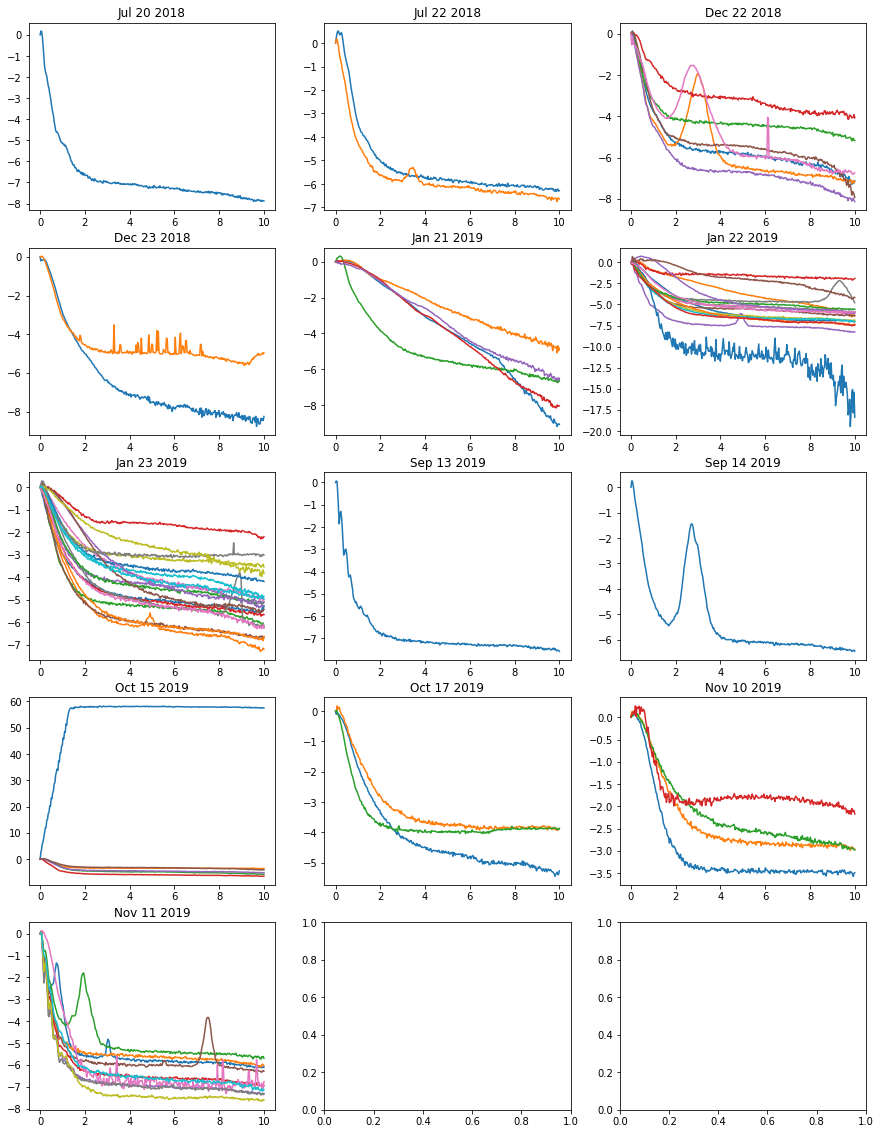

In [150]:
fig, axes = plt.subplots(5,3,figsize=(15,20))
axes_labels = [axes[0,0],axes[0,1],axes[0,2],axes[1,0],axes[1,1],axes[1,2],axes[2,0],axes[2,1],axes[2,2],
               axes[3,0],axes[3,1],axes[3,2],axes[4,0],axes[4,1],axes[4,2]]
for i in range(len(all_ks_data)):
    ax = axes_labels[i]
    for j in all_ks_data[i]:
        ax.plot(contrast_curve(j)[0],-1*contrast_curve(j)[1])
        ax.set_title(Ks_Dates[i])
        

In [ ]:
#Bad Ks ones
bad_ks_oct_15_2019 = all_ks_data[3,1]
bad_ks_dec_23_2018 = all_ks_data[9,0]
bad_ks_jan_22_2019 = all_ks_data[5,10]


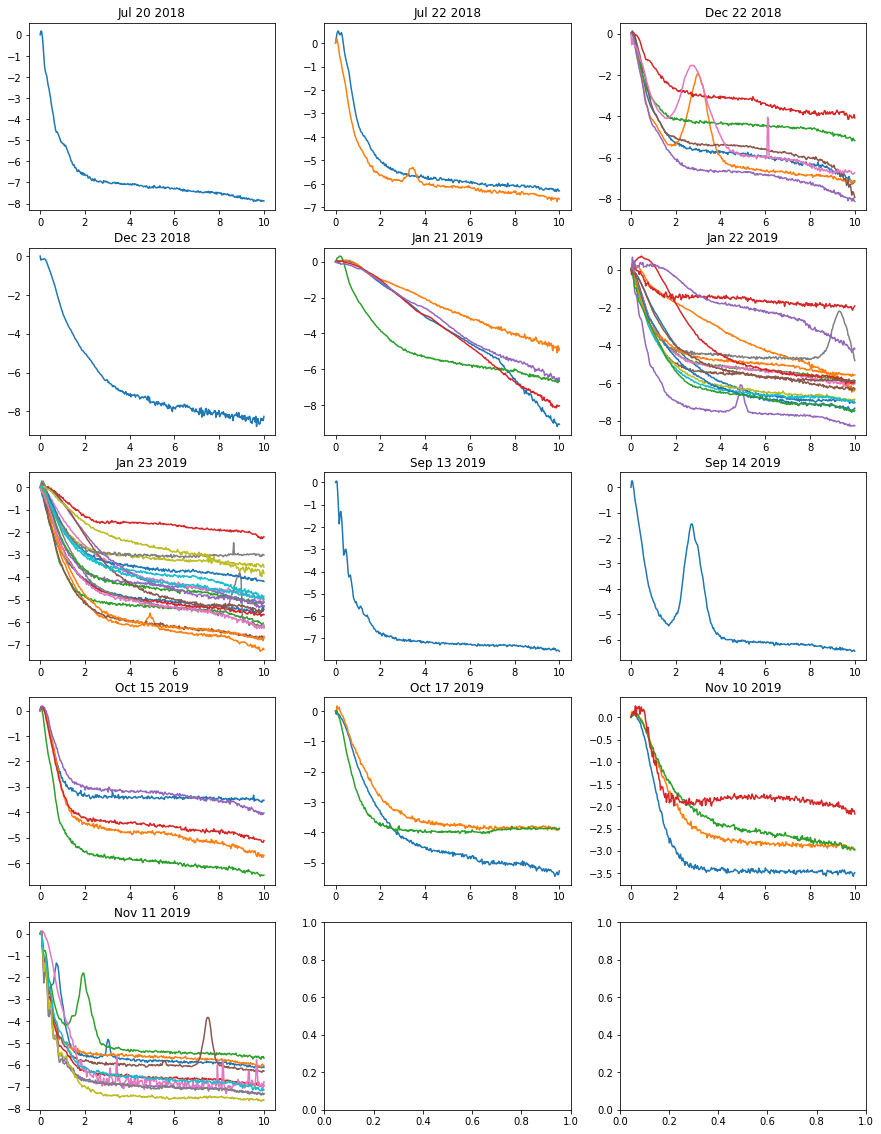

In [172]:
fig, axes = plt.subplots(5,3,figsize=(15,20))
axes_labels = [axes[0,0],axes[0,1],axes[0,2],axes[1,0],axes[1,1],axes[1,2],axes[2,0],axes[2,1],axes[2,2],
               axes[3,0],axes[3,1],axes[3,2],axes[4,0],axes[4,1],axes[4,2]]
for i in range(len(all_ks_data)):
    ax = axes_labels[i]
    for j in range(len(all_ks_data[i])):
        if ([i,j] !=[3,1]) and ([i,j] != [9,0]) and ([i,j]!=[5,10]):
            ax.plot(contrast_curve(all_ks_data[i][j])[0],-1*contrast_curve(all_ks_data[i][j])[1])
            ax.set_title(Ks_Dates[i])
        

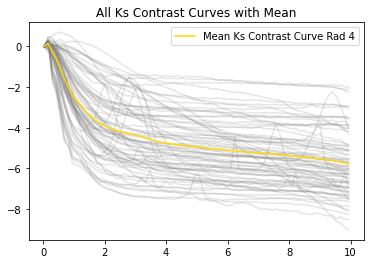

In [98]:
each_cc = []
for i in range(len(all_ks_data)):
    for j in range(len(all_ks_data[i])):
        if ([i,j] !=[3,1]) and ([i,j] != [9,0]) and ([i,j]!=[5,10]):
            cc = contrast_curve_3(all_ks_data[i][j],radius_size=4)
            each_cc.append(cc)
            plt.plot(cc[0],-1*cc[1],color='grey',alpha=0.2)
plt.title('All Ks Contrast Curves with Mean')

mean_cc_al = []
mean_cc_dm = []
for i in range(len(each_cc[0][0])):
    al = []
    dm = []
    for j in range(len(each_cc)):
        al.append(each_cc[j][0][i])
        dm.append(-1*each_cc[j][1][i])
    mean_cc_al.append(np.mean(al))
    mean_cc_dm.append(np.mean(dm))
plt.plot(mean_cc_al,mean_cc_dm,color='gold',label='Mean Ks Contrast Curve Rad 4')
plt.legend()
plt.show()
        

In [87]:
x_val_4 = []
x_val_6 = []
for i in range(len(all_ks_data)):
    for j in range(len(all_ks_data[i])):
        if ([i,j] != [3,1]) and ([i,j] != [9,0]) and ([i,j] != [5,10]):
            cc = contrast_curve_3(all_ks_data[i][j],radius_size=4)
            x_val_4.append(-1*cc[1][32])
            x_val_6.append(-1*cc[1][47])

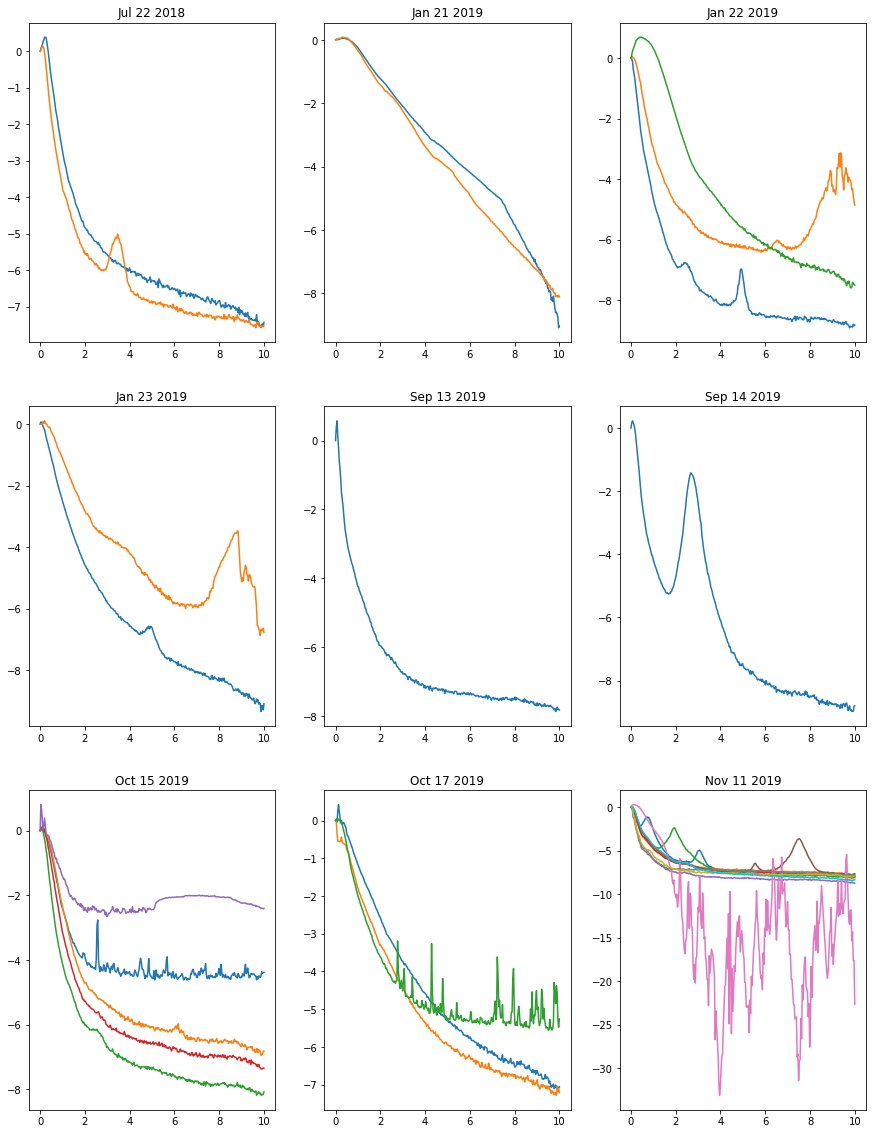

In [176]:
fig, axes = plt.subplots(3,3,figsize=(15,20))
axes_labels = [axes[0,0],axes[0,1],axes[0,2],axes[1,0],axes[1,1],axes[1,2],axes[2,0],axes[2,1],axes[2,2]]
for i in range(len(all_j_data)):
    ax = axes_labels[i]
    for j in range(len(all_j_data[i])):
        ax.plot(contrast_curve(all_j_data[i][j])[0],-1*contrast_curve(all_j_data[i][j])[1])
        ax.set_title(J_Dates[i])

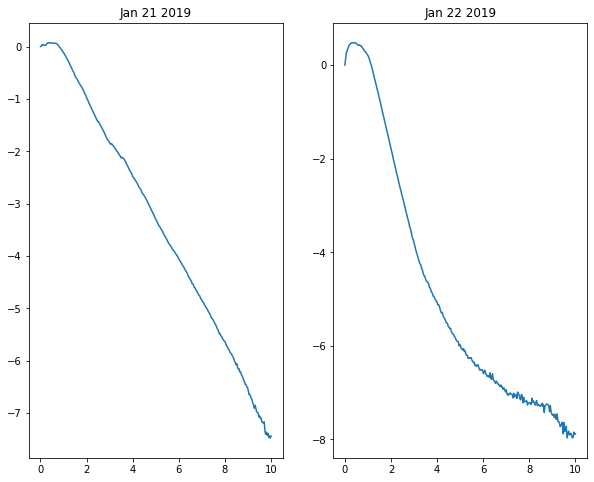

In [183]:
fig, axes = plt.subplots(1,2,figsize=(10,8))
axes_labels = [axes[0],axes[1]]
for i in range(len(all_h_data)):
    ax = axes_labels[i]
    for j in range(len(all_h_data[i])):
        ax.plot(contrast_curve(all_h_data[i][j])[0],-1*contrast_curve(all_h_data[i][j])[1])
        ax.set_title(H_Dates[i])

In [204]:
grad_0 = []
current = 0
previous = 0
grad_func = np.gradient(-contrast_curve(all_ks_data[12][7])[1])
CCfunc = contrast_curve(all_ks_data[12][7])[0]
for j in range(len(grad_func)):
    previous = current
    current=grad_func[j]
    if (previous>0 and current<0) or (previous<0 and current>0):
        grad_0.append(CCfunc[j])

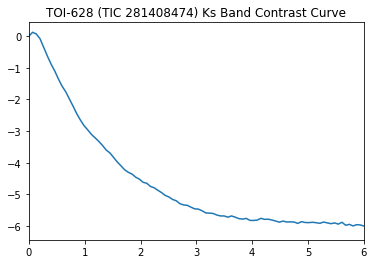

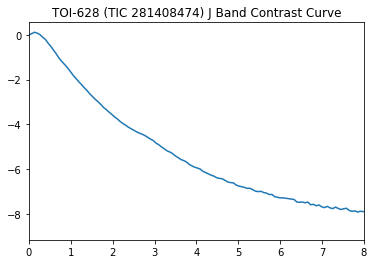

In [51]:
plt.plot(contrast_curve_3(dat[0].data,radius_size=2)[0],-1*contrast_curve_3(dat[0].data,radius_size=2)[1])
plt.xlim(0,6)
plt.title('TOI-628 (TIC 281408474) Ks Band Contrast Curve')
plt.show()

plt.plot(contrast_curve_3(dat2[0].data,radius_size=2)[0],-1*contrast_curve_3(dat2[0].data,radius_size=2)[1])
plt.xlim(0,8)
plt.title('TOI-628 (TIC 281408474) J Band Contrast Curve')
plt.show()

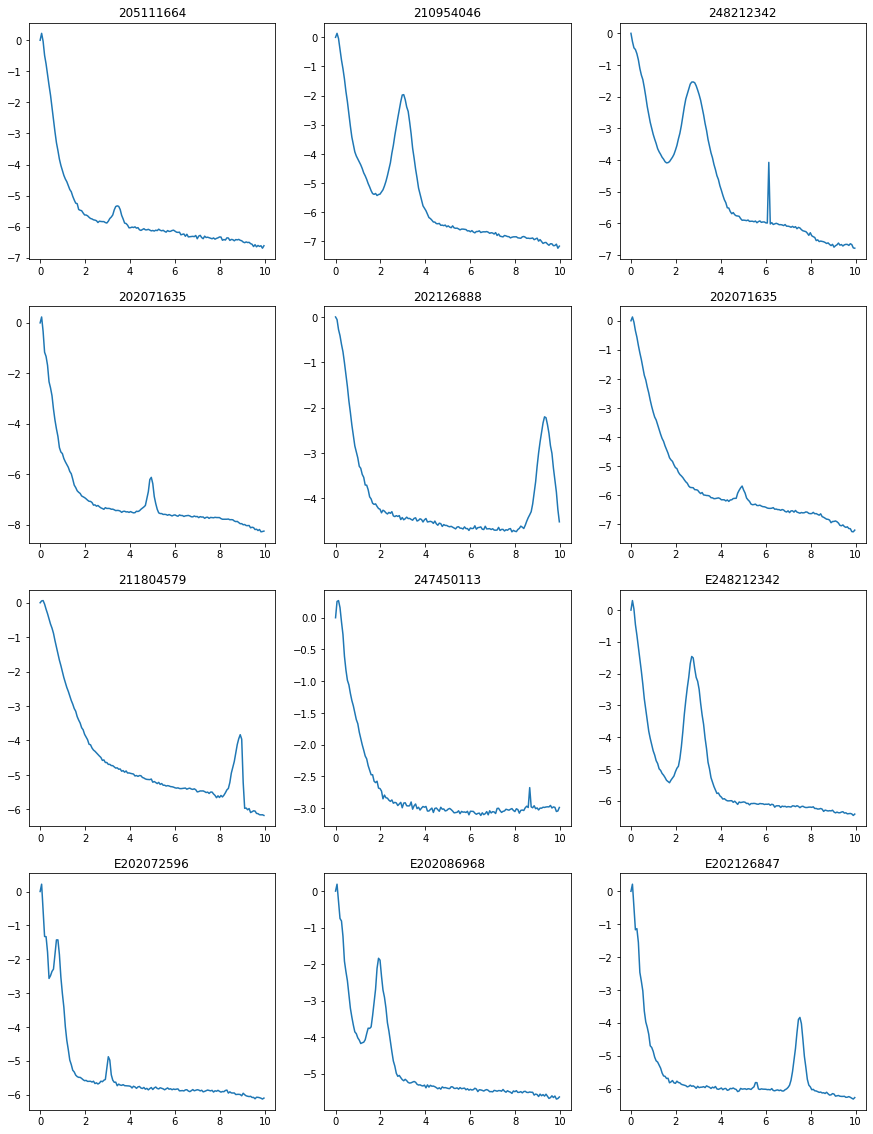

In [79]:

potential_ks_companions_data = [all_ks_data[1][1],all_ks_data[2][1],all_ks_data[2][6],all_ks_data[5][4],all_ks_data[5][7],
                          all_ks_data[6][1],all_ks_data[6][7],all_ks_data[6][17],all_ks_data[8][0],all_ks_data[12][0],
                          all_ks_data[12][2],all_ks_data[12][5]]
potential_ks_companions = [all_ks_names[1][1],all_ks_names[2][1],all_ks_names[2][6],all_ks_names[5][4],all_ks_names[5][7],
                          all_ks_names[6][1],all_ks_names[6][7],all_ks_names[6][17],all_ks_names[8][0],all_ks_names[12][0],
                          all_ks_names[12][2],all_ks_names[12][5]]

fig, axes = plt.subplots(4,3,figsize=(15,20))
axes_labels = [axes[0,0],axes[0,1],axes[0,2],axes[1,0],axes[1,1],axes[1,2],axes[2,0],axes[2,1],axes[2,2],
               axes[3,0],axes[3,1],axes[3,2]]
for i in range(len(potential_ks_companions_data)):
    ax = axes_labels[i]
    ax.plot(contrast_curve_3(potential_ks_companions_data[i],radius_size=2)[0],-1*contrast_curve_3(potential_ks_companions_data[i],radius_size=2)[1])
    ax.set_title(potential_ks_companions[i])
    #plt.xlim(0,6)

    

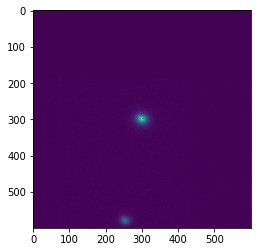

In [50]:
plt.imshow(all_ks_data[5][7])

In [17]:
test_center = all_ks_data[2][1][290:310,290:310]
#plt.plot(contrast_curve_3(test_center,radius_size=2)[0],-1*contrast_curve_3(test_center,radius_size=2)[1])
cc_2_1 = contrast_curve_3(all_ks_data[2][1],radius_size=6)

[-0.         -0.27304317]


In [22]:
cc_2_1

array([array([0.033, 0.231, 0.429, 0.627, 0.825, 1.023, 1.221, 1.419, 1.617,
       1.815, 2.013, 2.211, 2.409, 2.607, 2.805, 3.003, 3.201, 3.399,
       3.597, 3.795, 3.993, 4.191, 4.389, 4.587, 4.785, 4.983, 5.181,
       5.379, 5.577, 5.775, 5.973, 6.171, 6.369, 6.567, 6.765, 6.963,
       7.161, 7.359, 7.557, 7.755, 7.953, 8.151, 8.349, 8.547, 8.745,
       8.943, 9.141, 9.339, 9.537, 9.735, 9.933]),
       array([-0.        , -0.27304317,  0.62446212,  1.75251807,  3.00332824,
        3.88592571,  4.29069145,  4.67604784,  5.08132547,  5.35333033,
        5.39488492,  5.19971989,  4.70685517,  3.93474229,  3.004362  ,
        2.18275258,  2.13789533,  2.83987917,  4.07915568,  5.08028798,
        5.72764123,  6.05706116,  6.27286996,  6.37300856,  6.42326868,
        6.46544902,  6.50031884,  6.51586112,  6.57290273,  6.57987972,
        6.62224187,  6.65841527,  6.67486578,  6.66893738,  6.66833705,
        6.70214609,  6.71841627,  6.78662244,  6.8244638 ,  6.82666693,
        6

In [65]:
test = all_ks_data[2][6]
hotspots = []
for i in range(len(test)):
    for j in range(len(test[i])):
        if (i!=0 and i!=len(test) and j!=0 and j!=len(test)) and \
        (test[i][j]>100*(test[i-1][j]+1)):
            hotspots.append([i,j])

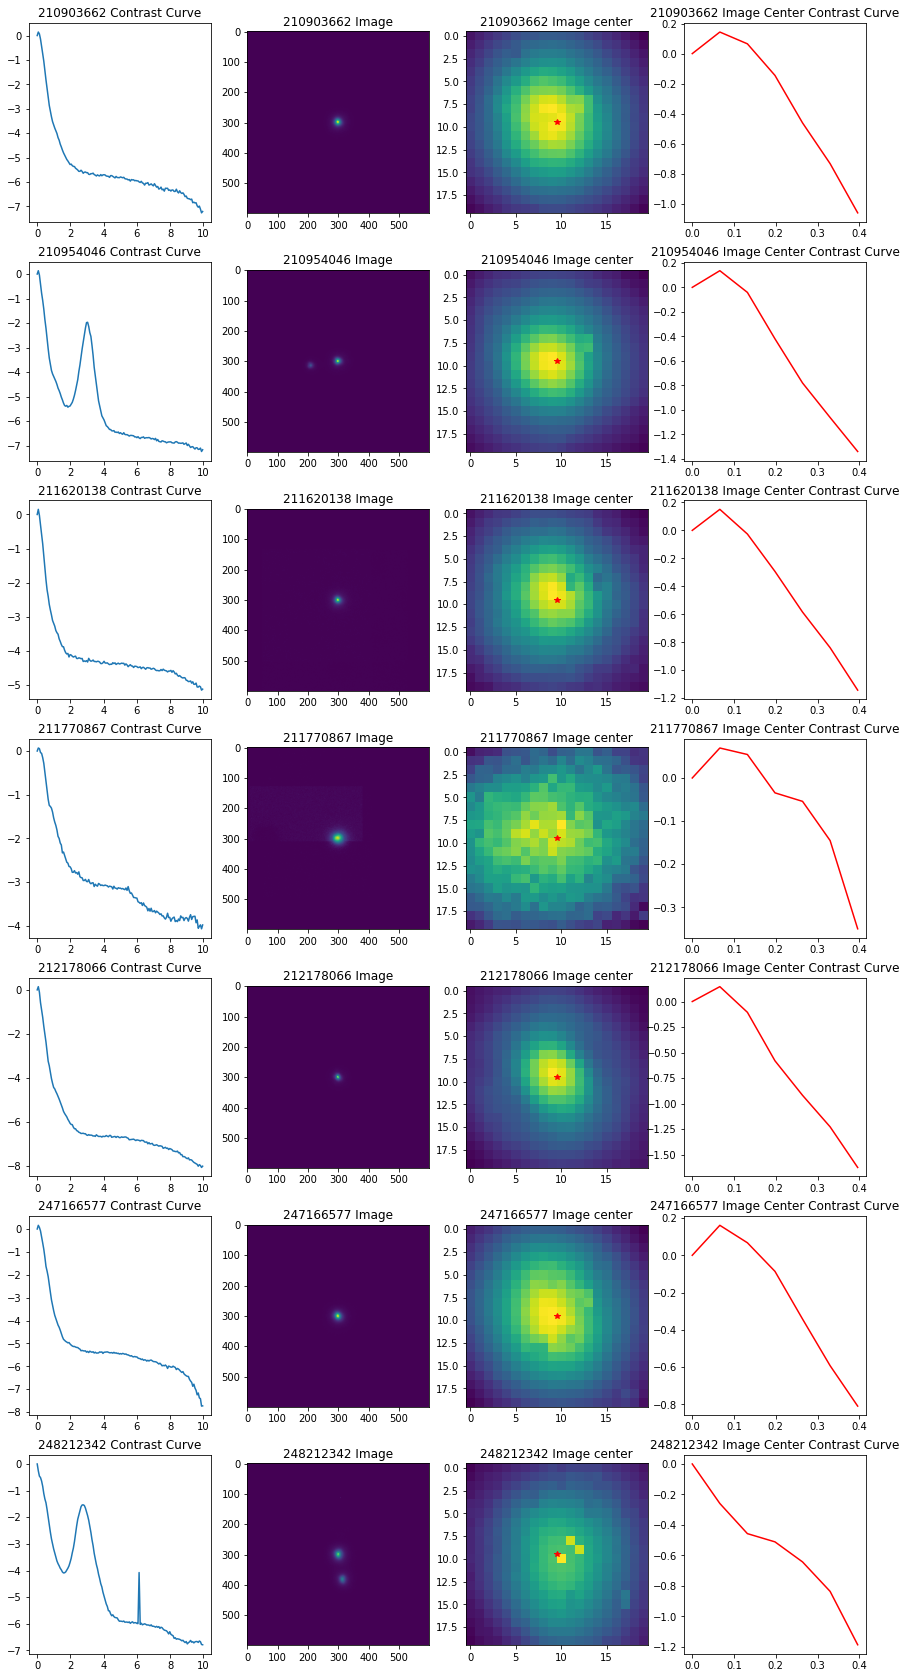

In [61]:

fig, axes = plt.subplots(7,4,figsize=(15,30))
for j in range(len(all_ks_data[2])):
    ax1 = axes[j,0]
    ax2 = axes[j,1]
    ax3 = axes[j,2]
    ax4 = axes[j,3]
    
    #marker = insertMarker(all_ks_data[2][j][290:310][290:310],[299,299])
    
    ax1.plot(contrast_curve_3(all_ks_data[2][j],radius_size=2)[0],-1*contrast_curve_3(all_ks_data[2][j],radius_size=2)[1])
    ax2.imshow(all_ks_data[2][j])
    ax3.imshow(all_ks_data[2][j][290:310,290:310])
    ax3.plot(9.5,9.5,'r*')
    ax4.plot(contrast_curve_3(all_ks_data[2][j][290:310,290:310],radius_size=2)[0],-1*contrast_curve_3(all_ks_data[2][j][290:310,290:310],radius_size=2)[1],color='red')
    
    ax1.set_title(Dec_22_2018_Ks_stars[j] + ' Contrast Curve')
    ax2.set_title(Dec_22_2018_Ks_stars[j] + ' Image')
    ax3.set_title(Dec_22_2018_Ks_stars[j] + ' Image center')
    ax4.set_title(Dec_22_2018_Ks_stars[j] + ' Image Center Contrast Curve')

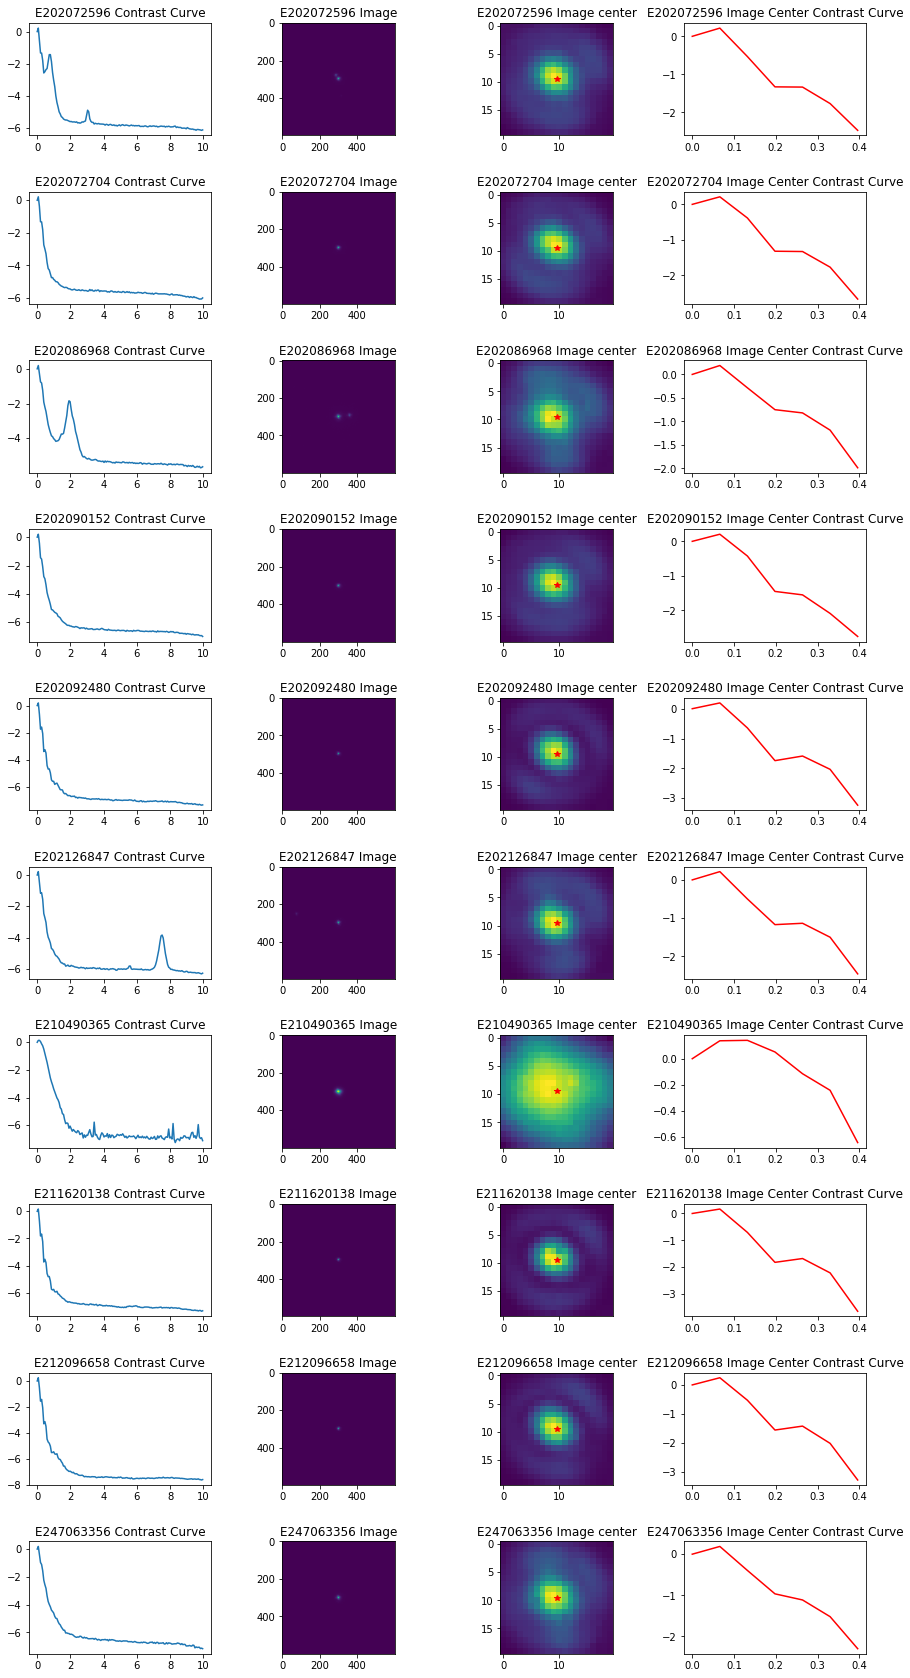

In [62]:

fig, axes = plt.subplots(len(all_ks_data[12]),4,figsize=(15,30))
for j in range(len(all_ks_data[12])):
    ax1 = axes[j,0]
    ax2 = axes[j,1]
    ax3 = axes[j,2]
    ax4 = axes[j,3]
        
    ax1.plot(contrast_curve_3(all_ks_data[12][j],radius_size=2)[0],-1*contrast_curve_3(all_ks_data[12][j],radius_size=2)[1])
    ax2.imshow(all_ks_data[12][j])
    ax3.imshow(all_ks_data[12][j][290:310,290:310])
    ax3.plot(9.5,9.5,'r*')
    ax4.plot(contrast_curve_3(all_ks_data[12][j][290:310,290:310],radius_size=2)[0],-1*contrast_curve_3(all_ks_data[12][j][290:310,290:310],radius_size=2)[1],color='red')
    
    ax1.set_title(Nov_11_2019_Ks_stars[j] + ' Contrast Curve')
    ax2.set_title(Nov_11_2019_Ks_stars[j] + ' Image')
    ax3.set_title(Nov_11_2019_Ks_stars[j] + ' Image center')
    ax4.set_title(Nov_11_2019_Ks_stars[j] + ' Image Center Contrast Curve')

plt.subplots_adjust(hspace=.5)

In [123]:
def cc_quad(data,center=None,radius_size=1):    
    
    x, y = np.indices((data.shape))
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
        
    center_x1,center_x2 = int(center[0]-.5) ,int(center[0]+.5)
    center_y1,center_y2 = int(center[1]-.5),int(center[1]+.5)
    center_points = (data[center_x1,center_y1],data[center_x1,center_y2],data[center_x2,center_y1],data[center_x2,center_y2])
    center_val = np.mean(center_points) + 5*np.std(center_points)
    
    radii =  np.sqrt((x - center[0])**2 + (y - center[1])**2)
    radii = radii.astype(np.int)


    center_val1,center_val2,center_val3,center_val4 = data[299,299],data[299,300],data[300,299],data[300,300]


    
    number_of_a = radii.max()/radius_size
    if radius_size>1:
        for i in range(int(number_of_a)+2):
            if i==0:
                continue
            radii[(radii>0) & (radii<=i*radius_size) & (radii>radius_size*(i-1))] =(i)
            
    
    radii_arc_length = []
    for i in range(radii.max()):
        radii_arc_length.append(i*0.033*radius_size)
    radii_arc_length = np.array(radii_arc_length)
    lim_arc_length= radii_arc_length[radii_arc_length<10]
    
    bins1,bins2,bins3,bins4 = [],[],[],[]
    for i in range(radii.max()+1):
        bins1.append([])
        bins2.append([])
        bins3.append([])
        bins4.append([])
    
    for i in range(len(radii)):
        for j in range(len(radii[i])):
            if i<300 and j<300:
                bins1[radii[i,j]].append(np.array([i,j]))
            if i<300 and j>299:
                bins2[radii[i,j]].append(np.array([i,j]))
            if i>299 and j<300:
                bins3[radii[i,j]].append(np.array([i,j]))
            if i>299 and j>299:
                bins4[radii[i,j]].append(np.array([i,j]))
    bins1 = bins1[:len(lim_arc_length)]
    bins2 = bins2[:len(lim_arc_length)]
    bins3 = bins3[:len(lim_arc_length)]
    bins4 = bins4[:len(lim_arc_length)]


    
    radii_bin_vals1,radii_bin_vals2,radii_bin_vals3,radii_bin_vals4 = [],[],[],[]
    for i in range(len(bins1)):
        radii_bin1 = []
        for j in range(len(bins1[i])):
            radii_bin1.append(data[bins1[i][j][0],bins1[i][j][1]])
        radii_bin_vals1.append(radii_bin1)
    for i in range(len(bins2)):
        radii_bin2 = []
        for j in range(len(bins2[i])):
            radii_bin2.append(data[bins2[i][j][0],bins2[i][j][1]])
        radii_bin_vals2.append(radii_bin2)
    for i in range(len(bins3)):
        radii_bin3 = []
        for j in range(len(bins3[i])):
            radii_bin3.append(data[bins3[i][j][0],bins3[i][j][1]])
        radii_bin_vals3.append(radii_bin3)
    for i in range(len(bins4)):
        radii_bin4 = []
        for j in range(len(bins4[i])):
            radii_bin4.append(data[bins4[i][j][0],bins4[i][j][1]])
        radii_bin_vals4.append(radii_bin4)

    radii_deltas1,radii_deltas2,radii_deltas3,radii_deltas4 = [],[],[],[]

    for i in radii_bin_vals1:
        if np.mean(i)>0:
            radii_deltas1.append(-2.5 * math.log((np.mean(i) + 5*np.std(i))/center_val1,10))
    for i in radii_bin_vals2:
        if np.mean(i)>0:
            radii_deltas2.append(-2.5 * math.log((np.mean(i) + 5*np.std(i))/center_val2,10))
    for i in radii_bin_vals3:
        if np.mean(i)>0:
            radii_deltas3.append(-2.5 * math.log((np.mean(i) + 5*np.std(i))/center_val3,10))
    for i in radii_bin_vals4:
        if np.mean(i)>0:
            radii_deltas4.append(-2.5 * math.log((np.mean(i) + 5*np.std(i))/center_val4,10))
    
    radii_deltas1=np.array(radii_deltas1)
    radii_deltas2=np.array(radii_deltas2)
    radii_deltas3=np.array(radii_deltas3)
    radii_deltas4=np.array(radii_deltas4)
    
    fig,axes = plt.subplots(2,4,figsize=(10,10))
    
    lim_arc_length1 = lim_arc_length[:len(radii_deltas1)]
    lim_arc_length2 = lim_arc_length[:len(radii_deltas2)]
    lim_arc_length3 = lim_arc_length[:len(radii_deltas3)]
    lim_arc_length4 = lim_arc_length[:len(radii_deltas4)]


    
    ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axes[0,0],axes[0,1],axes[0,2],axes[0,3],axes[1,0],axes[1,1],axes[1,2],axes[1,3]
    ax1.plot(lim_arc_length1,-1*radii_deltas1)
    ax2.imshow(data[0:300,0:300])
    ax3.imshow(data[0:300,300:])
    ax4.plot(lim_arc_length2,-1*radii_deltas2)
    ax5.plot(lim_arc_length3,-1*radii_deltas3)
    ax6.imshow(data[300:,0:300])
    ax7.imshow(data[300:,300:])
    ax8.plot(lim_arc_length4,-1*radii_deltas4)
    

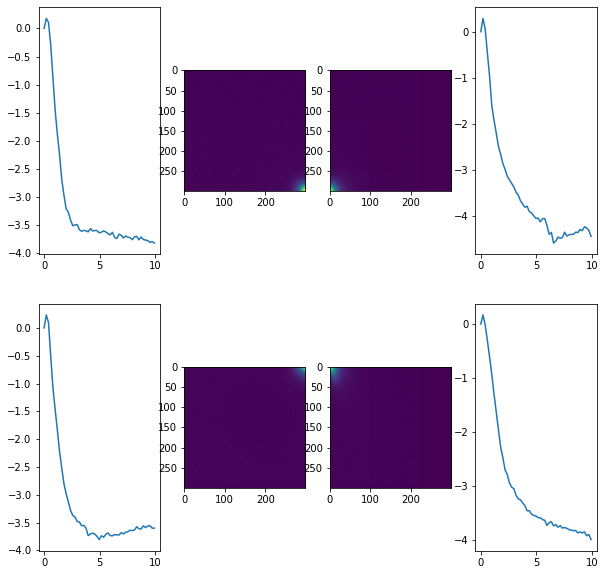

In [128]:
cc_quad(all_ks_data[10][1],radius_size=6)

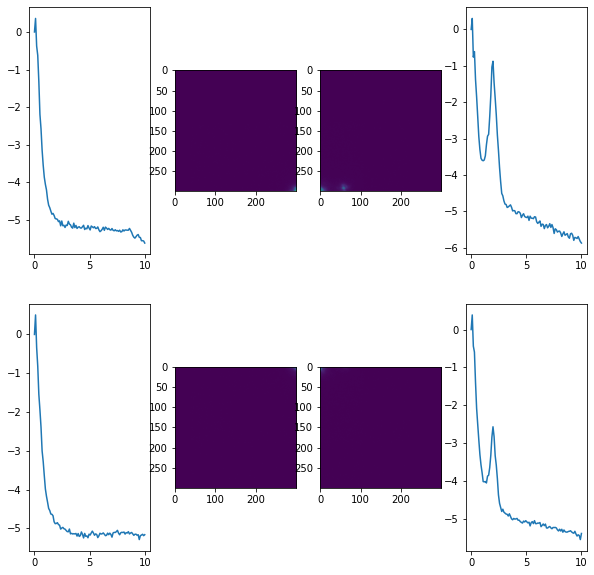

In [124]:
cc_quad(all_ks_data[12][2],radius_size=3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


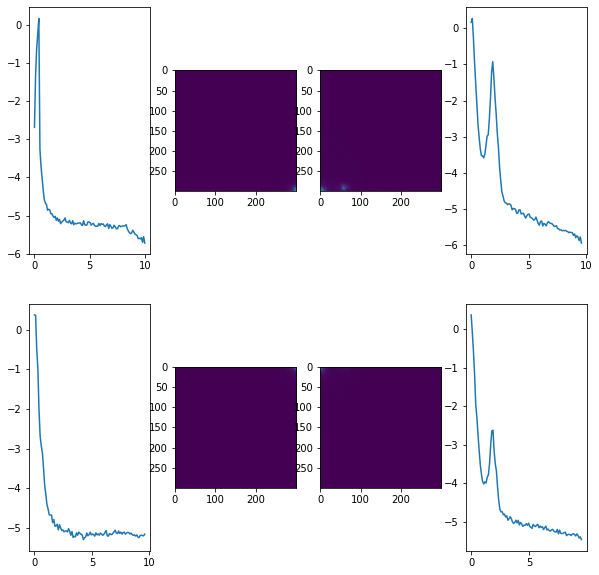

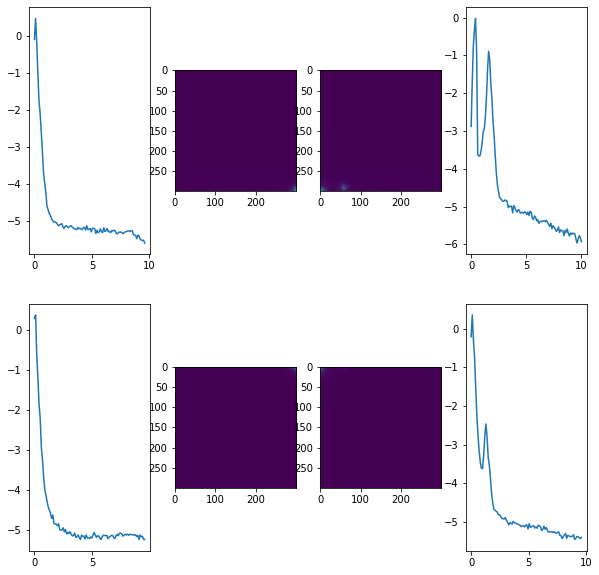

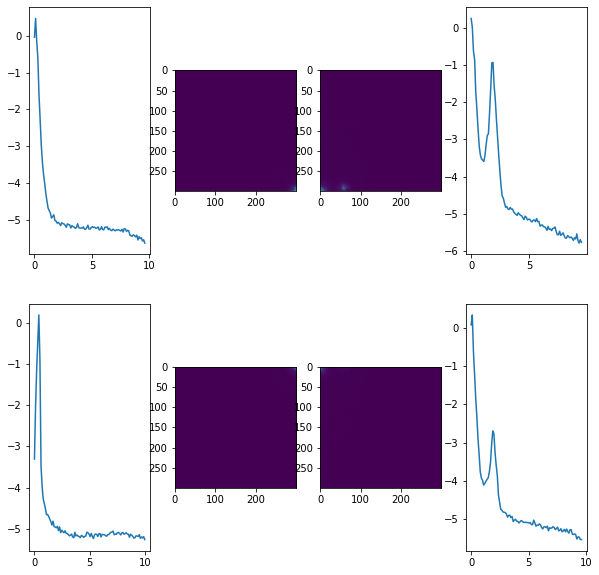

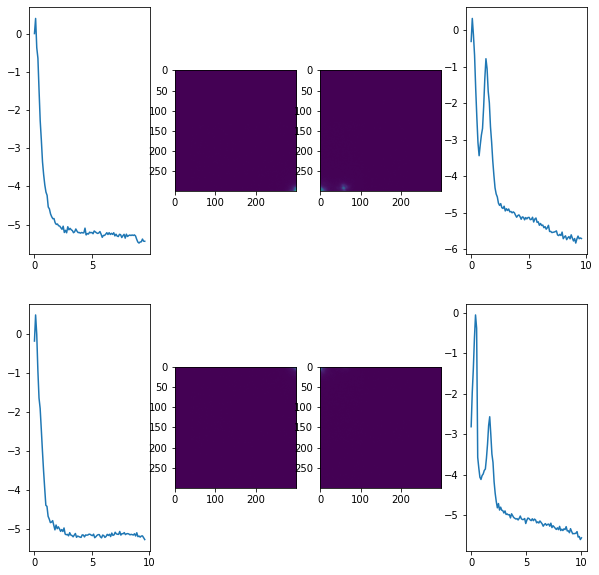

In [127]:
try_centers = [[290,290],[290,310],[310,290],[310,310]]
for i in try_centers:
    cc_quad(all_ks_data[12][2],center=i,radius_size=3)

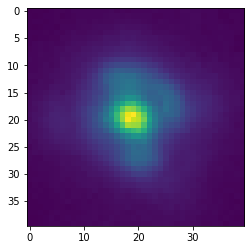

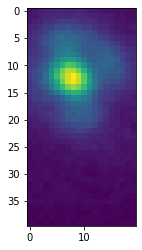

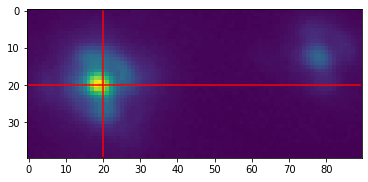

In [86]:
test = all_ks_data[12][2]
linspace1 = np.linspace(0,89,100)
linspace2 = np.linspace(0,39,100)
plt.imshow(test[280:320,280:320])
plt.show()
plt.imshow(test[280:320,350:370])
plt.show()
plt.imshow(test[280:320,280:370])
plt.plot(linspace1,0*linspace1+20,color='red')
plt.plot(0*linspace2+20,linspace2,color='red')

In [94]:
np.sum(test[300:320,300:350])/np.sum(test[300:320,370:390])

21.78410981958299

In [95]:
np.sum(test[280:300,300:350])/np.sum(test[280:300,370:390])

12.079733954638828

doing something
hot pixel alert: 252.10810530467324 at [181, 387]
hot pixel alert: 135.23912528072486 at [182, 387]
hot pixel alert: 108.31534389065261 at [223, 186]
hot pixel alert: 95.65133348399438 at [223, 405]
hot pixel alert: 98.1099107909674 at [231, 237]
hot pixel alert: 95.8294824954268 at [235, 236]
hot pixel alert: 104.17989654016682 at [267, 291]
hot pixel alert: 96.93500447227913 at [267, 298]
hot pixel alert: 99.83369221908396 at [267, 300]
hot pixel alert: 96.39750856449498 at [267, 301]
hot pixel alert: 101.75042415554151 at [268, 291]
hot pixel alert: 101.86412516854881 at [268, 292]
hot pixel alert: 104.57778533832291 at [268, 294]
hot pixel alert: 97.03855966970971 at [268, 295]
hot pixel alert: 110.65696810414605 at [268, 296]
hot pixel alert: 101.46387025027369 at [268, 297]
hot pixel alert: 99.19060597380945 at [268, 298]
hot pixel alert: 104.55664159420752 at [268, 299]
hot pixel alert: 106.94944988502455 at [268, 300]
hot pixel alert: 112.54594772287001 at [268,

hot pixel alert: 101.50192489337311 at [299, 337]
hot pixel alert: 114.59456853059527 at [300, 266]
hot pixel alert: 100.14030162280406 at [300, 267]
hot pixel alert: 147.64201006242496 at [300, 268]
hot pixel alert: 154.30511979328804 at [300, 269]
hot pixel alert: 150.30322563010338 at [300, 331]
hot pixel alert: 128.36553228688885 at [300, 332]
hot pixel alert: 118.36721920351938 at [300, 333]
hot pixel alert: 120.48063639363252 at [300, 334]
hot pixel alert: 107.29672681807764 at [300, 335]
hot pixel alert: 96.84393068239936 at [300, 337]
hot pixel alert: 111.6405512273996 at [301, 266]
hot pixel alert: 125.07784633974387 at [301, 267]
hot pixel alert: 145.1029269667975 at [301, 268]
hot pixel alert: 146.78693926732598 at [301, 269]
hot pixel alert: 149.65752463997666 at [301, 331]
hot pixel alert: 134.88858099685183 at [301, 332]
hot pixel alert: 127.62847913095186 at [301, 333]
hot pixel alert: 119.05286063249966 at [301, 334]
hot pixel alert: 123.06758738700691 at [301, 335]
hot

hot pixel alert: 552.6396342310863 at [376, 289]
hot pixel alert: 131.09904996666396 at [376, 291]
hot pixel alert: 658.9798055948381 at [377, 289]
hot pixel alert: 99.45625990313373 at [413, 21]
hot pixel alert: 109.2463938959954 at [419, 20]
hot pixel alert: 122.7047714024747 at [427, 386]
hot pixel alert: 119.95815323228943 at [431, 327]
hot pixel alert: 160.0505362076718 at [432, 327]
hot pixel alert: 139.06669078387856 at [434, 325]
hot pixel alert: 97.75979893060182 at [435, 325]
hot pixel alert: 202.19732986761034 at [457, 460]
hot pixel alert: 171.63885724295997 at [471, 292]
hot pixel alert: 115.93006250723431 at [472, 291]
hot pixel alert: 247.58777746294632 at [472, 292]
hot pixel alert: 101.13224798233577 at [473, 23]
hot pixel alert: 97.3980544082589 at [491, 119]
hot pixel alert: 137.42067868224862 at [529, 141]
hot pixel alert: 99.30211742464145 at [580, 170]


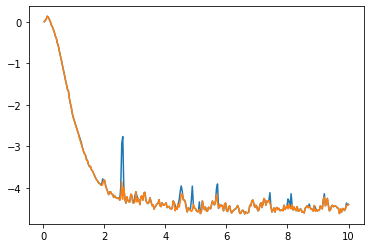

In [80]:
test_cc = contrast_curve_3(all_j_data[6][0],radius_size=1)
test_cc2 = contrast_curve_3(all_j_data[6][0],remove_hot=True,radius_size=1)
plt.plot(test_cc[0],-1*test_cc[1])
plt.plot(test_cc2[0],-1*test_cc2[1])

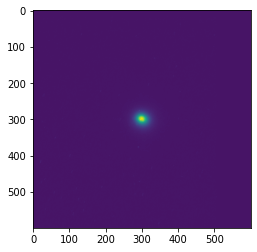

In [102]:
plt.imshow(all_j_data[6][0])
plt.show()

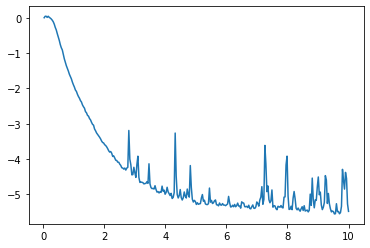

In [77]:
plt.plot(contrast_curve_3(all_j_data[7][2])[0],-1*contrast_curve_3(all_j_data[7][2])[1])

doing something
hot pixel alert: 261.5648627412968 at [62, 11]
hot pixel alert: 502.1129714386529 at [63, 11]
hot pixel alert: 207.75573731618894 at [132, 86]
hot pixel alert: 473.8020590863611 at [143, 14]
hot pixel alert: 270.4360012279078 at [144, 14]
hot pixel alert: 355.8700533716645 at [153, 0]
hot pixel alert: 232.34119765812878 at [154, 0]
hot pixel alert: 260.2524487857855 at [186, 391]
hot pixel alert: 271.37290834661025 at [209, 322]
hot pixel alert: 626.855290710197 at [228, 190]
hot pixel alert: 420.31853316875777 at [229, 190]
hot pixel alert: 247.29159670868435 at [238, 34]
hot pixel alert: 500.2345569830012 at [239, 240]
hot pixel alert: 325.7962021706354 at [240, 240]
hot pixel alert: 210.9404015283439 at [264, 293]
hot pixel alert: 209.07703507576946 at [264, 296]
hot pixel alert: 215.7924836455495 at [264, 298]
hot pixel alert: 217.25103810561424 at [264, 301]
hot pixel alert: 207.9522206518818 at [264, 302]
hot pixel alert: 216.21601661837943 at [264, 303]
hot pixel

hot pixel alert: 210.58569022724822 at [312, 266]
hot pixel alert: 228.0404251047994 at [312, 267]
hot pixel alert: 237.24624523411143 at [312, 268]
hot pixel alert: 254.14917679542395 at [312, 269]
hot pixel alert: 251.2474860341573 at [312, 331]
hot pixel alert: 233.56385172663818 at [312, 332]
hot pixel alert: 227.5046025036926 at [312, 333]
hot pixel alert: 207.66399151931216 at [312, 334]
hot pixel alert: 223.0589795649505 at [313, 267]
hot pixel alert: 224.80017152903955 at [313, 268]
hot pixel alert: 246.30690851884486 at [313, 269]
hot pixel alert: 259.5374757888217 at [313, 331]
hot pixel alert: 245.6441412249792 at [313, 332]
hot pixel alert: 220.9214749756042 at [313, 333]
hot pixel alert: 215.1902384795605 at [313, 334]
hot pixel alert: 219.0995771706783 at [314, 267]
hot pixel alert: 221.41577004250502 at [314, 268]
hot pixel alert: 237.7578141131352 at [314, 269]
hot pixel alert: 254.1176833502239 at [314, 331]
hot pixel alert: 232.11107377805013 at [314, 332]
hot pixel a

hot pixel alert: 380.09984576109593 at [404, 106]
hot pixel alert: 237.08638099493464 at [405, 106]
hot pixel alert: 255.09716464779046 at [421, 25]
hot pixel alert: 218.80147102779063 at [437, 8]
hot pixel alert: 561.7076635701322 at [492, 193]
hot pixel alert: 326.65603514033586 at [493, 193]
hot pixel alert: 412.2046016643694 at [500, 432]
hot pixel alert: 237.2471981456855 at [507, 62]
hot pixel alert: 269.3665055638834 at [533, 145]
hot pixel alert: 276.1739386025266 at [534, 145]
hot pixel alert: 378.1209172700456 at [555, 143]
hot pixel alert: 225.96235328439684 at [565, 115]
hot pixel alert: 275.5273693661694 at [565, 324]
hot pixel alert: 417.26765939543486 at [592, 350]
hot pixel alert: 286.08621426956995 at [593, 350]
doing something
hot pixel alert: 261.5648627412968 at [62, 11]
hot pixel alert: 502.1129714386529 at [63, 11]
hot pixel alert: 207.75573731618894 at [132, 86]
hot pixel alert: 473.8020590863611 at [143, 14]
hot pixel alert: 270.4360012279078 at [144, 14]
hot pi

hot pixel alert: 212.06484695681186 at [305, 265]
hot pixel alert: 232.62893886056992 at [305, 266]
hot pixel alert: 267.7834150475429 at [305, 267]
hot pixel alert: 269.105457935896 at [305, 268]
hot pixel alert: 302.07988106949415 at [305, 269]
hot pixel alert: 290.21840411344385 at [305, 331]
hot pixel alert: 271.03288833292544 at [305, 332]
hot pixel alert: 267.05557625180427 at [305, 333]
hot pixel alert: 254.01051085593065 at [305, 334]
hot pixel alert: 223.30171261181272 at [305, 335]
hot pixel alert: 222.69489543572627 at [305, 336]
hot pixel alert: 223.74394529267892 at [306, 265]
hot pixel alert: 235.98519874119853 at [306, 266]
hot pixel alert: 255.0810319045819 at [306, 267]
hot pixel alert: 266.17655828494776 at [306, 268]
hot pixel alert: 306.02986994864636 at [306, 269]
hot pixel alert: 290.30786848614946 at [306, 331]
hot pixel alert: 281.6029290602029 at [306, 332]
hot pixel alert: 264.63551987444293 at [306, 333]
hot pixel alert: 249.97728819258225 at [306, 334]
hot p

hot pixel alert: 238.12882896752973 at [337, 307]
hot pixel alert: 222.56610219740924 at [337, 308]
hot pixel alert: 226.57829208573074 at [337, 309]
hot pixel alert: 219.4516115077887 at [337, 310]
hot pixel alert: 224.11254045174803 at [337, 311]
hot pixel alert: 213.35384276007005 at [337, 312]
hot pixel alert: 216.54582528485244 at [337, 313]
hot pixel alert: 208.31402529480704 at [337, 314]
hot pixel alert: 230.84780664621138 at [338, 294]
hot pixel alert: 207.80213301841854 at [338, 295]
hot pixel alert: 226.48385082996737 at [338, 296]
hot pixel alert: 232.787865550339 at [338, 297]
hot pixel alert: 222.1840138885213 at [338, 298]
hot pixel alert: 225.11270454926697 at [338, 299]
hot pixel alert: 232.822701358028 at [338, 300]
hot pixel alert: 214.52451704371754 at [338, 301]
hot pixel alert: 222.93388810409556 at [338, 302]
hot pixel alert: 239.98541823665514 at [338, 303]
hot pixel alert: 220.46347586057192 at [338, 304]
hot pixel alert: 222.2109842497734 at [338, 305]
hot pix

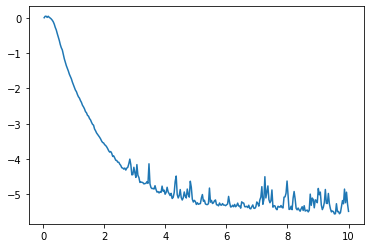

In [81]:
plt.plot(contrast_curve_3(all_j_data[7][2],remove_hot=True)[0],-1*contrast_curve_3(all_j_data[7][2],remove_hot=True)[1])

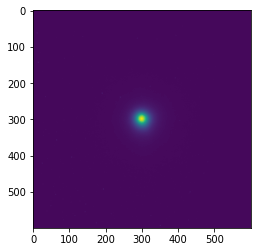

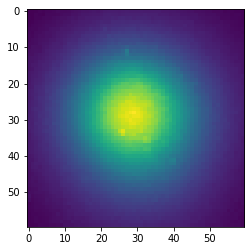

In [101]:
plt.imshow(all_j_data[7][2])
plt.show()
plt.imshow(all_j_data[7][2][270:330,270:330])

In [122]:
def hot_cold(data,center=None):
    
    star_data=data.copy()
    
    x, y = np.indices((star_data.shape))
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
        
    center_x1,center_x2 = int(center[0]-.5) ,int(center[0]+.5)
    center_y1,center_y2 = int(center[1]-.5),int(center[1]+.5)
    center_points = (star_data[center_x1,center_y1],star_data[center_x1,center_y2],star_data[center_x2,center_y1],star_data[center_x2,center_y2])
    center_val = np.mean(center_points)/(4) + 5*np.std(center_points)
    
    radii =  np.sqrt((x - center[0])**2 + (y - center[1])**2)
    radii = radii.astype(np.int)

    
    non_center = []
    for i in range(len(star_data)):
        for j in range(len(star_data[i])):
            if i<250 or i>350 or j<250 or j>350:
                non_center.append(star_data[i,j])
    background_mean = np.mean(non_center)
    background_std = np.std(non_center)
    #print(background_mean)
    #print(background_std)
    
    hot_guys = []
    for i in range(600):
        for j in range(600):
            if (i<240 or i>360 or j<240 or j>360) & (star_data[i,j]>(background_mean+10*background_std)):
                hot_guys.append([i,j])
                star_data[i,j] = 10000
            elif (i<240 or i>360 or j<240 or j>360):
                star_data[i,j] = 0
            else:
                star_data[i,j] = 0
    print('number of designated hot pixels:',len(hot_guys))
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    axes[0,0].imshow(star_data[:300,:300],cmap='bwr')
    axes[0,1].imshow(star_data[:300,300:],cmap='bwr')
    axes[1,0].imshow(star_data[300:,:300],cmap='bwr')
    axes[1,1].imshow(star_data[300:,300:],cmap='bwr')

number of designated hot pixels: 158


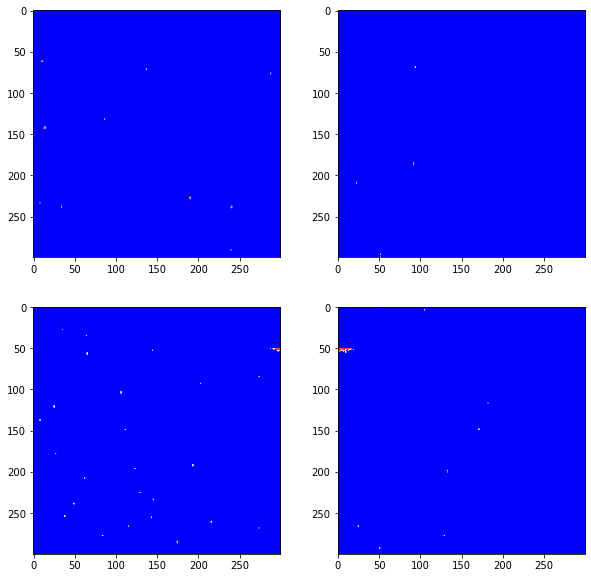

In [99]:
hot_cold(all_j_data[7][2])

number of designated hot pixels: 463


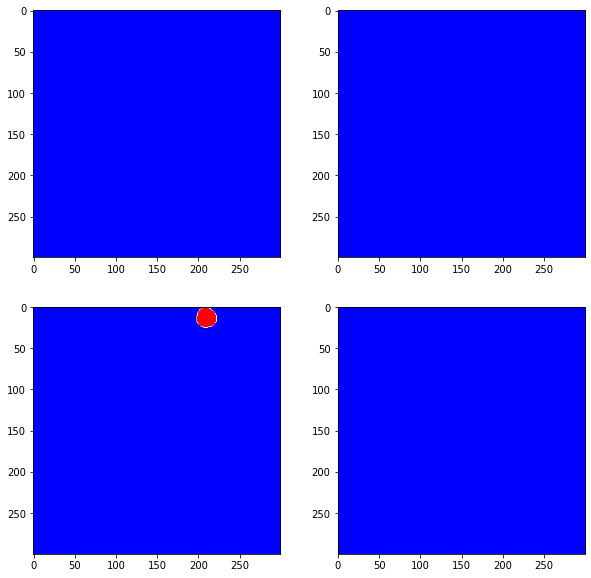

In [101]:
hot_cold(all_ks_data[2][1])

number of designated hot pixels: 39


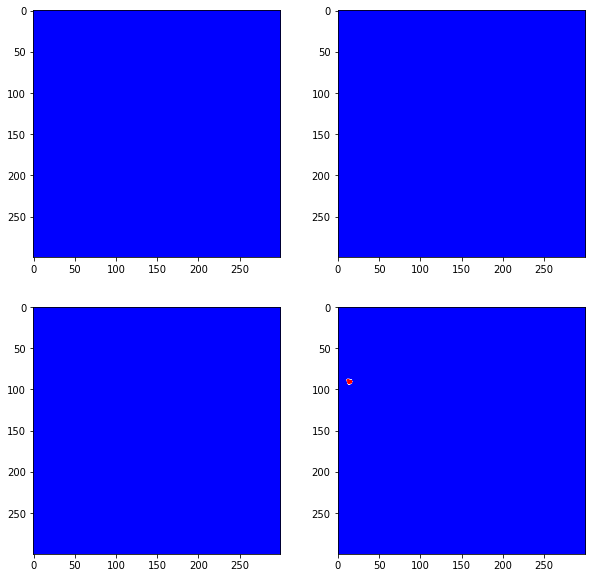

In [106]:
hot_cold(all_ks_data[12][0])

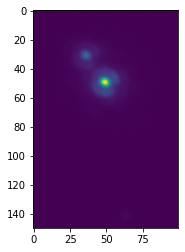

In [113]:
plt.imshow(all_ks_data[12][0][250:400,250:350])

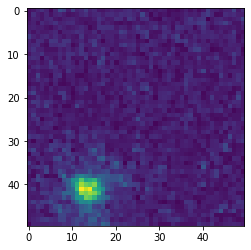

In [112]:
plt.imshow(all_ks_data[12][0][350:400,300:350])

number of designated hot pixels: 0


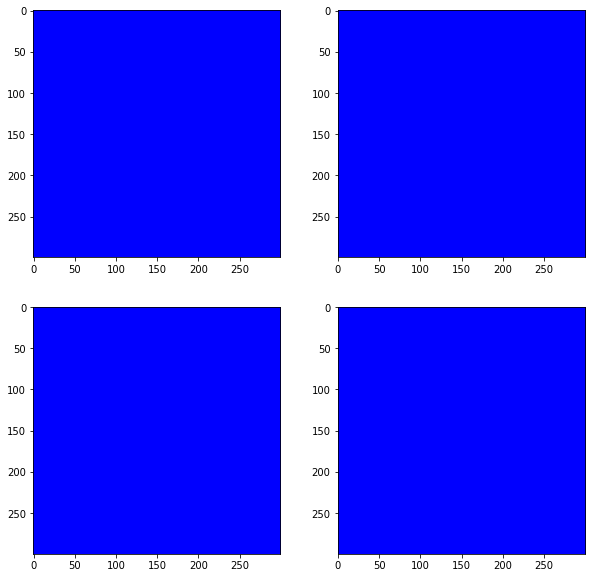

In [123]:
hot_cold(all_ks_data[10][0])

number of designated hot pixels: 1


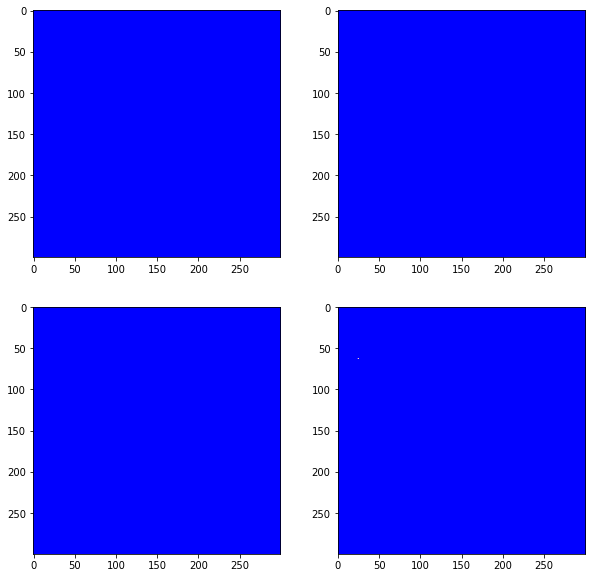

In [124]:
hot_cold(all_ks_data[10][1])

number of designated hot pixels: 5


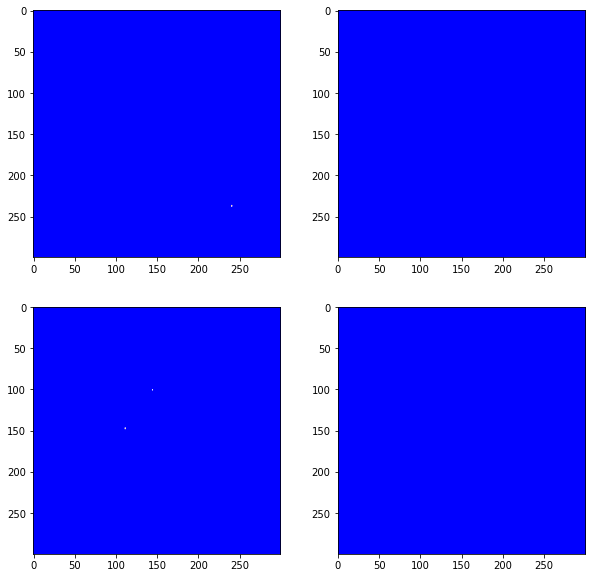

In [125]:
hot_cold(all_ks_data[10][2])

number of designated hot pixels: 323


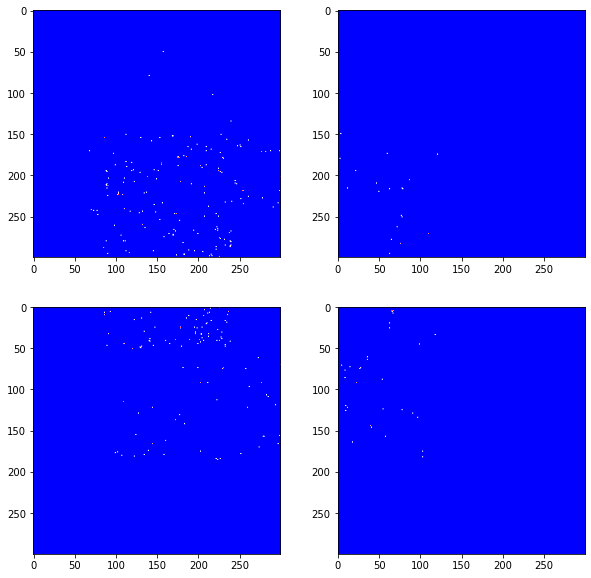

In [127]:
hot_cold(all_ks_data[5][10])